In [302]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

from scipy import stats
from scipy.stats import norm, skew #for some statistics

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points


In [303]:
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')

train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL       65.000     8450   Pave   NaN      Reg   
1   2          20       RL       80.000     9600   Pave   NaN      Reg   
2   3          60       RL       68.000    11250   Pave   NaN      IR1   
3   4          70       RL       60.000     9550   Pave   NaN      IR1   
4   5          60       RL       84.000    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [304]:
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

## Data processing

lets get rid of outliers on the right side of plot

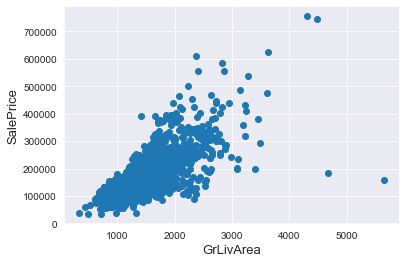

In [305]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

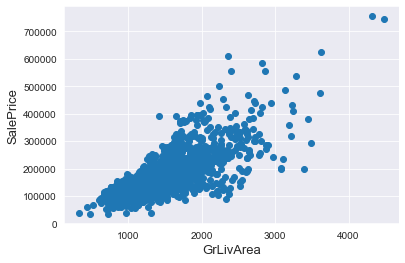

In [306]:
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()


 mu = 180932.92 and sigma = 79467.79



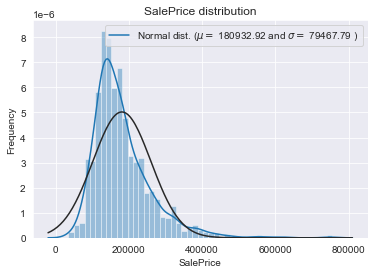

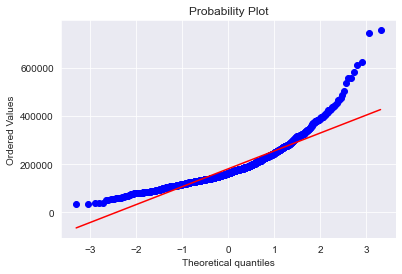

In [307]:
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

Linear regressors apparently work better if data is distributed normally


 mu = 12.02 and sigma = 0.40



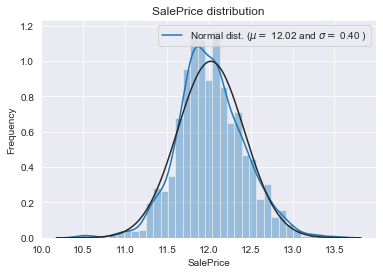

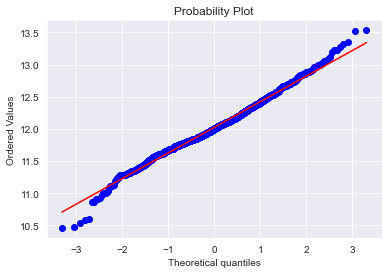

In [308]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

In [309]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


In [310]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

Missing Ratio
PoolQC               99.691
MiscFeature          96.400
Alley                93.212
Fence                80.425
FireplaceQu          48.680
LotFrontage          16.661
GarageFinish          5.451
GarageQual            5.451
GarageCond            5.451
GarageYrBlt           5.451
GarageType            5.382
BsmtExposure          2.811
BsmtCond              2.811
BsmtQual              2.777
BsmtFinType2          2.743
BsmtFinType1          2.708
MasVnrType            0.823
MasVnrArea            0.788
MSZoning              0.137
BsmtFullBath          0.069

<AxesSubplot:>

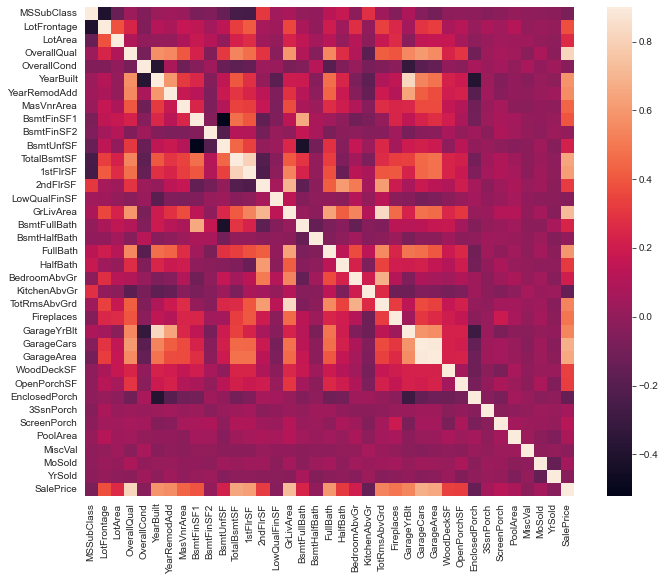

In [311]:
#Correlation map to see how features are correlated with SalePrice
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [312]:
create_fetures = True

if create_fetures:
    all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
    all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
    all_data["Alley"] = all_data["Alley"].fillna("None")
    all_data["Fence"] = all_data["Fence"].fillna("None")
    all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
    all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
        lambda x: x.fillna(x.median()))
    for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
        all_data[col] = all_data[col].fillna('None')
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        all_data[col] = all_data[col].fillna(0)
    for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
        all_data[col] = all_data[col].fillna(0)
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        all_data[col] = all_data[col].fillna('None')
    all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
    all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
    all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
    all_data = all_data.drop(['Utilities'], axis=1)
    all_data["Functional"] = all_data["Functional"].fillna("Typ")
    all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
    all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
    all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
    all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
    all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
    all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")


We can just throw all missing data away. It works, there is no major correlation going on between subjects with missing values. But it appears to be worth it to keep all labels

In [313]:
if not create_fetures:
    total = all_data.isnull().sum().sort_values(ascending=False)
    percent = (all_data.isnull().sum()/all_data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    missing_data.head(20)

    all_data = all_data.drop((missing_data[missing_data['Total'] > 1]).index, 1)
    all_data = all_data.drop(all_data.loc[all_data['Electrical'].isnull()].index)

    # is there any data missing?
    all_data.isnull().sum().max()

In [314]:
#Check remaining missing values if any
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

Empty DataFrame
Columns: [Missing Ratio]
Index: []

In [315]:
if create_fetures:
    all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

    #Changing OverallCond into a categorical variable
    all_data['OverallCond'] = all_data['OverallCond'].astype(str)

    #Year and month sold are transformed into categorical features.
    all_data['YrSold'] = all_data['YrSold'].astype(str)
    all_data['MoSold'] = all_data['MoSold'].astype(str)

In [316]:
from sklearn.preprocessing import LabelEncoder

if create_fetures:
    cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
            'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
            'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
            'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
            'YrSold', 'MoSold')
    # process columns, apply LabelEncoder to categorical features
    for c in cols:
        lbl = LabelEncoder() 
        lbl.fit(list(all_data[c].values)) 
        all_data[c] = lbl.transform(list(all_data[c].values))

    # shape        
    print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


In [317]:
if create_fetures:

    # Adding total sqfootage feature 
    all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [318]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



Skew
MiscVal       21.940
PoolArea      17.689
LotArea       13.109
LowQualFinSF  12.085
3SsnPorch     11.372
LandSlope      4.973
KitchenAbvGr   4.301
BsmtFinSF2     4.145
EnclosedPorch  4.002
ScreenPorch    3.945

In [319]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

There are 59 skewed numerical features to Box Cox transform


In [320]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 220)


In [321]:
fixed_train = all_data[:ntrain]
fixed_test = all_data[ntrain:]

In [322]:
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [323]:
#Validation function
n_folds = 5

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(fixed_train.values)
    rmse= np.sqrt(-cross_val_score(model, fixed_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [324]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1115 (0.0074)



In [325]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =41)

# Why it takes more then 5 minutes to do grid search on 3 models???
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'n_estimators': [3000],
#     'learning_rate': [0.05, 0.1, 0.2],
#     'max_depth': [3],
# }

# GBoost = GradientBoostingRegressor()
# GBoost = GridSearchCV(GBoost, param_grid)

score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1177 (0.0081)



In [326]:
model_xgb = xgb.XGBRegressor(learning_rate=0.05, max_depth=3, n_estimators=2200)

score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1180 (0.0092)



In [327]:
model_xgb.fit(fixed_train, y_train)
xgb_train_pred = model_xgb.predict(fixed_train)
xgb_pred = np.expm1(model_xgb.predict(fixed_test))
print(rmsle(y_train, xgb_pred))

sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = xgb_pred
sub.to_csv('submission.csv',index=False)

ValueError: Found input variables with inconsistent numbers of samples: [1458, 1459]